# Select M dwarfs through heuristics

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
import pandas as pd
from astropy.io import fits
%config InlineBackend.figure_format='retina'

### Read in [Gaia-Kepler.fun](https://gaia-kepler.fun) 
A cross match of Gaia DR3 with Kepler by Meg Bedell

In [2]:
hdus = fits.open('../../data/Gaia/kepler_dr3_good.fits')

In [3]:
tab = Table()
for col in hdus[1].columns:
    tab[col.name] = hdus[1].data[col.name]

In [4]:
df = tab.to_pandas()

In [5]:
df.tail()

,kepid,ra_kic,dec_kic,source_id,random_index,ra,dec,parallax,parallax_error,parallax_over_error,...,mass_err2,prov_sec,nconfp,nkoi,ntce,jmag,hmag,kmag,planet?,kepler_gaia_mag_diff
196757,12984227,290.07986,52.453712,2139330189463960320,1434812375,290.079838,52.453692,0.246011,0.018616,13.214761,...,-0.484,DSEP,0,0,0,8.505,7.589,7.295,none,-0.332914
196758,12984288,290.11249,52.415588,2139329875927860736,662936371,290.112599,52.415592,0.005198,0.055361,0.093884,...,-0.157,DSEP,0,0,0,16.289,15.603,15.306,none,-0.235144
196759,12984307,290.12332,52.474621,2139330636140575616,923414311,290.123462,52.474735,1.779882,0.009830,181.061508,...,-0.375,DSEP,0,0,0,11.459,11.104,11.075,none,-0.035185
196760,12984404,290.17230,52.423828,2139329467909467008,595517067,290.172325,52.423856,0.707362,0.009949,71.101357,...,-2.250,DSEP,0,0,0,9.851,9.212,9.095,none,-0.027551
196761,12984422,290.18420,52.404362,2139329399189739392,1570613422,290.184199,52.404460,0.975763,0.024997,39.035137,...,-0.102,DSEP,0,0,0,14.314,13.814,13.747,none,-0.040604


### Criterion 1: $T_\mathrm{eff}$ and $\log{g}$ cuts

In [18]:
criterion1 = (df.teff > 3400) & (df.teff < 3700)

In [19]:
criterion1.sum()

1903

### Criterion 2: Logg

[]

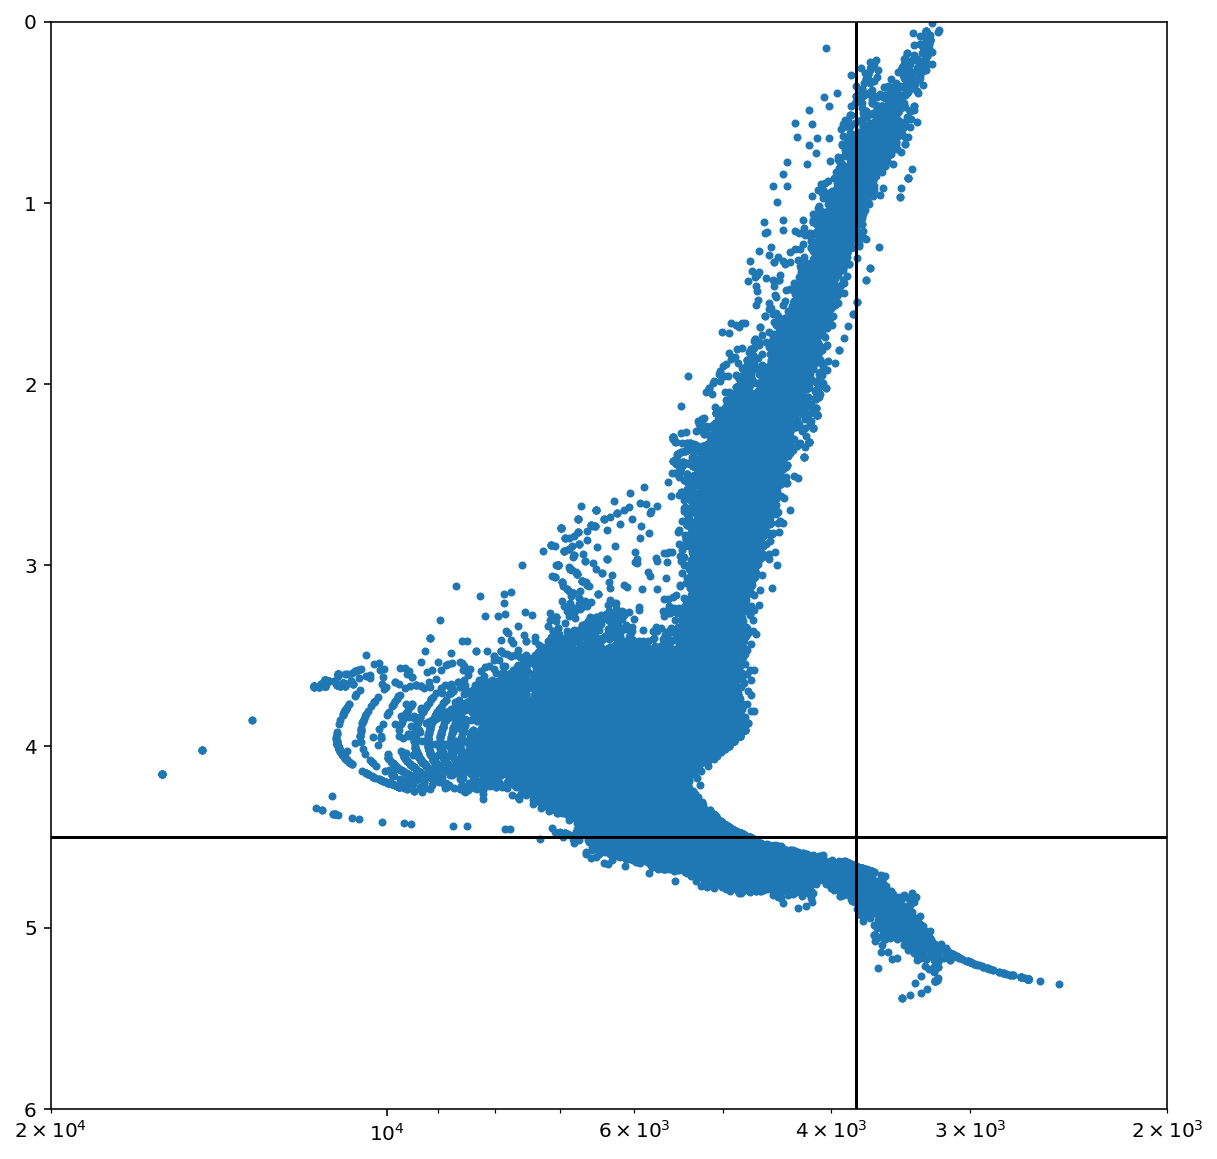

In [20]:
plt.figure(figsize=(10,10))
plt.plot(df.teff, df.logg, '.')
plt.xlim(20000, 2000)
plt.ylim(6, 0)
plt.axvline(3800, color='k')
plt.axhline(4.5, color='k')
plt.semilogx()

In [21]:
criterion2 = df.logg > 4.5

In [22]:
dataslice = df[criterion1 & criterion2]
sample = dataslice['kepid']

In [24]:
sample

378        1431845
403        1432978
483        1569863
800        1724234
995        1867358
            ...   
196298    12689927
196547    12784183
196551    12784248
196635    12834301
196693    12884812
Name: kepid, Length: 1499, dtype: int64

# 1499 targets available

# Spot check a couple in FFIs

In [25]:
times = np.array([54945.74206,54945.8670833,54946.0182163,54946.2335259,54946.3377372,54946.5495655,
                  54946.7334679,54947.1662509,55062.8253608,55091.0055606,55123.0864583,55153.9797114,
                  55182.0366329,55215.9548927,55216.0352649,55245.7660019,55274.7398619,55307.5350333,
                  55336.4281441,55370.695297,55399.0571196,55430.8109392,55461.8291274,55492.8064711,
                  55522.7621353,55552.0843583,55585.5760016,55614.7389024,55677.4444762,55706.6440223,
                  55738.4591443,55769.477399,55801.7624176,55832.8010616,55864.8001316,55895.757043,
                  55930.8619526,55958.4268791,55986.5230115,56014.5579184,56047.5173675,56077.4525238,
                  56105.5895974,56137.5273556,56168.8315615,56203.8547584,56236.834641,56267.9141396,
                  56303.6729488,56330.563549,56357.495041,56390.4952381])

ffidata = pd.read_csv('../../data/f3/lc_data_new.out')

In [34]:
index = 902
kicid = sample.iloc[index]

Text(0.5, 1.0, '9581885')

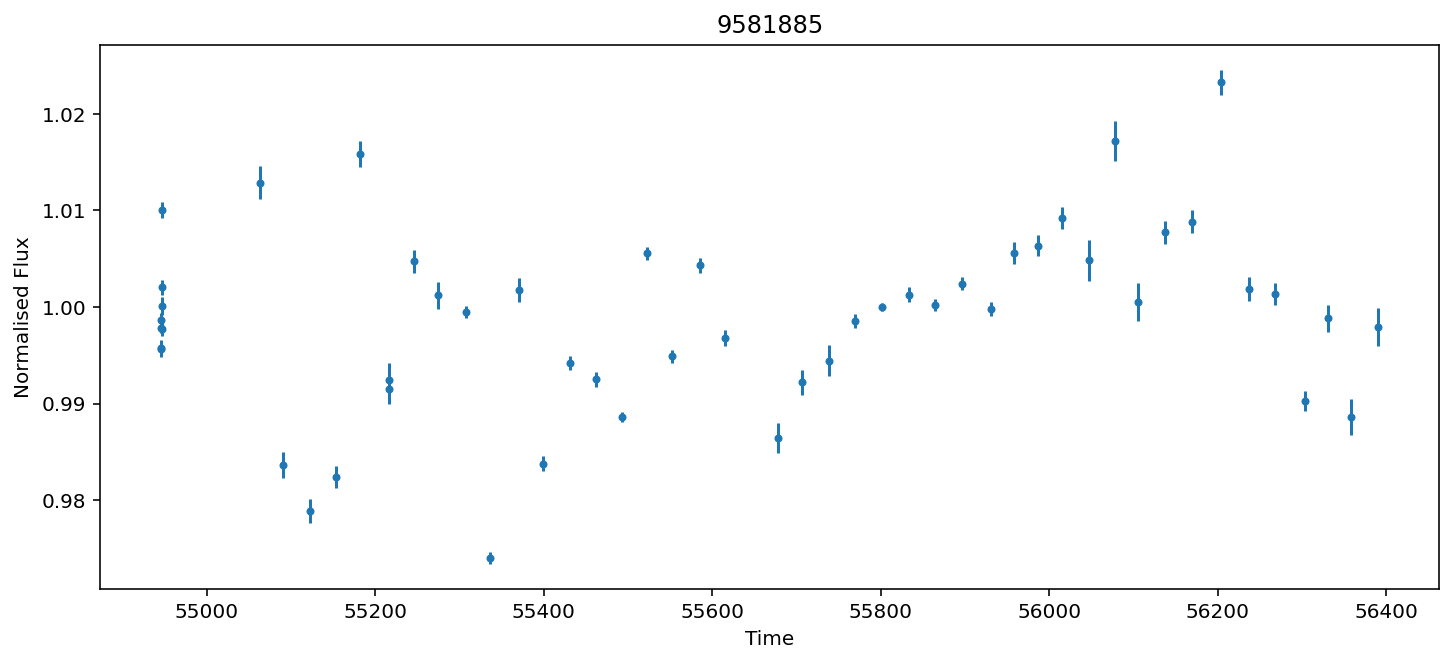

In [35]:
flux = ffidata[ffidata['KIC'] == kicid].iloc[:,1:53]
yerr = ffidata[ffidata['KIC'] == kicid].iloc[:,-52:]

plt.figure(figsize=(12,5))
plt.errorbar(times, np.asarray(flux)[0], yerr=np.asarray(yerr)[0], fmt='.')
plt.xlabel('Time')
plt.ylabel('Normalised Flux')
plt.title(kicid)

# let's get the rotation periods --- and the ones without measured rotation periods

In [36]:
rot_table = Table.read('../../data/literature/apjs492452t1_mrt.txt', format='cds').to_pandas()
no_rot_table = Table.read('../../data/literature/apjs492452t2_mrt.txt', format='cds').to_pandas()

rot_table['heritage'] = 1
no_rot_table['heritage'] = 2

In [37]:
combined_mcquillan = pd.concat([rot_table, no_rot_table], )

In [38]:
combined_mcquillan

,KIC,Teff,log(g),Mass,PRot,e_PRot,Rper,LPH,w,DC,Flag,heritage
0,892376,3813,4.47,0.4699,1.532,0.007,7306.69,0.823,0.4503,0,---,1
1,1026146,4261,4.57,0.6472,14.891,0.120,11742.56,1.405,0.7229,0,---,1
2,1026474,4122,4.56,0.5914,1.569,0.006,30471.80,1.204,0.6061,0,---,1
3,1162635,3760,4.77,0.4497,15.678,0.019,10207.47,0.978,0.5445,1,---,1
4,1164102,4045,4.62,0.5606,31.496,0.474,5139.74,0.568,0.3939,0,---,1
...,...,...,...,...,...,...,...,...,...,...,...,...
98995,12935010,4776,4.40,0.7756,29.986,3.730,NaN,0.269,0.1523,0,NaN,2
98996,12935127,4769,4.56,0.7737,NaN,NaN,NaN,NaN,NaN,0,NaN,2
98997,12984183,5176,4.49,0.8798,24.754,1.705,NaN,0.285,0.1650,0,NaN,2
98998,12984200,5621,4.46,0.9975,NaN,NaN,NaN,NaN,NaN,0,NaN,2


In [39]:
with_prot = pd.merge(dataslice, combined_mcquillan, left_on='kepid', right_on='KIC', how='left')

In [40]:
with_prot.heritage.value_counts(dropna=False)

1.0    825
NaN    556
2.0    118
Name: heritage, dtype: int64

In [41]:
with_prot[(with_prot.heritage==2) &(with_prot.PRot==with_prot.PRot)]['PRot']

5       53.792
11      21.833
48      29.542
74      60.177
119      0.960
         ...  
1445    36.546
1452    67.569
1458    28.270
1466    44.923
1477    42.149
Name: PRot, Length: 69, dtype: float64

### Spot check some of these long period ones

Text(0.5, 1.0, '4142890')

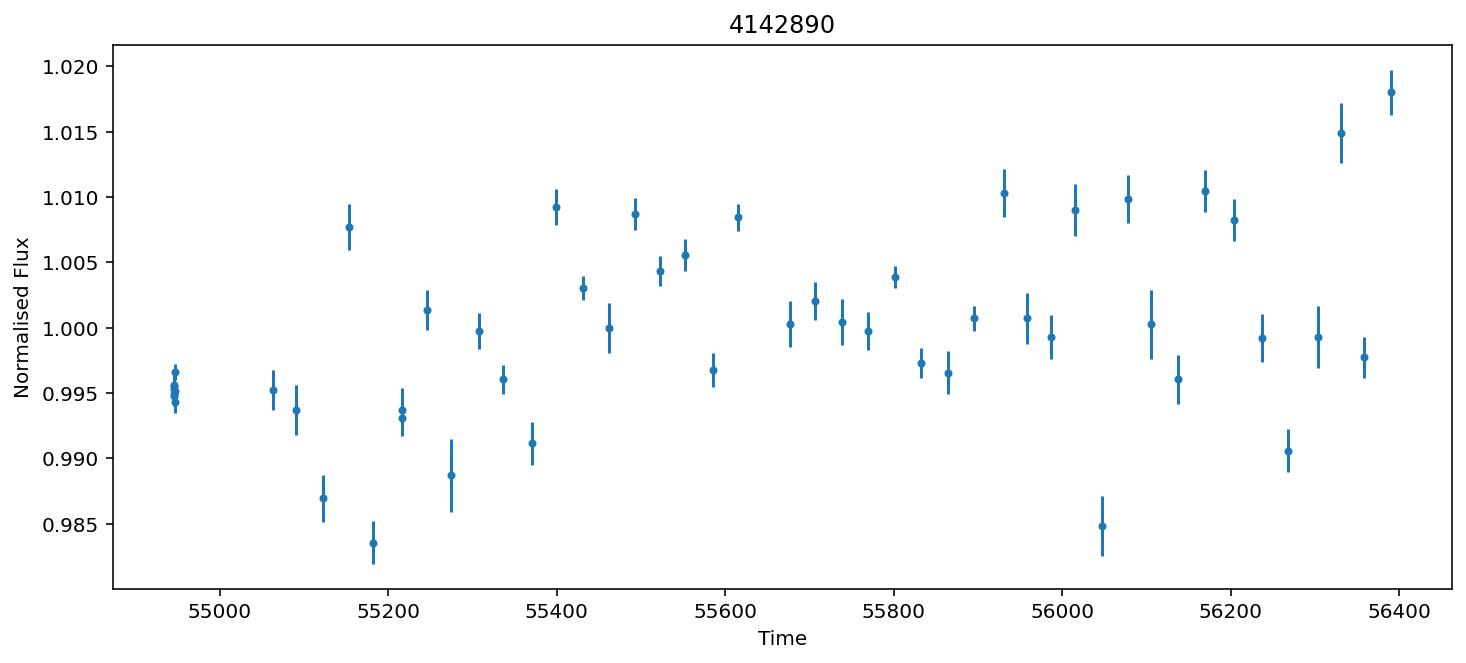

In [50]:
kepid = with_prot.iloc[123].kepid
flux = ffidata[ffidata['KIC'] == kepid].iloc[:,1:53]
yerr = ffidata[ffidata['KIC'] == kepid].iloc[:,-52:]

plt.figure(figsize=(12,5))
plt.errorbar(times, np.asarray(flux)[0], yerr=np.asarray(yerr)[0], fmt='.')
plt.xlabel('Time')
plt.ylabel('Normalised Flux')
plt.title(kepid)

### Add some summary statistics from the F3 lcs

In [51]:
with_prot['f3_std'] = np.NaN

In [52]:
for index in with_prot.index.values:
    kepid = with_prot.iloc[index].kepid
    flux = ffidata[ffidata['KIC'] == kepid].iloc[:,1:53]
    yerr = ffidata[ffidata['KIC'] == kepid].iloc[:,-52:]

    with_prot.loc[index, 'f3_std'] = np.std(np.asarray(flux)[0])

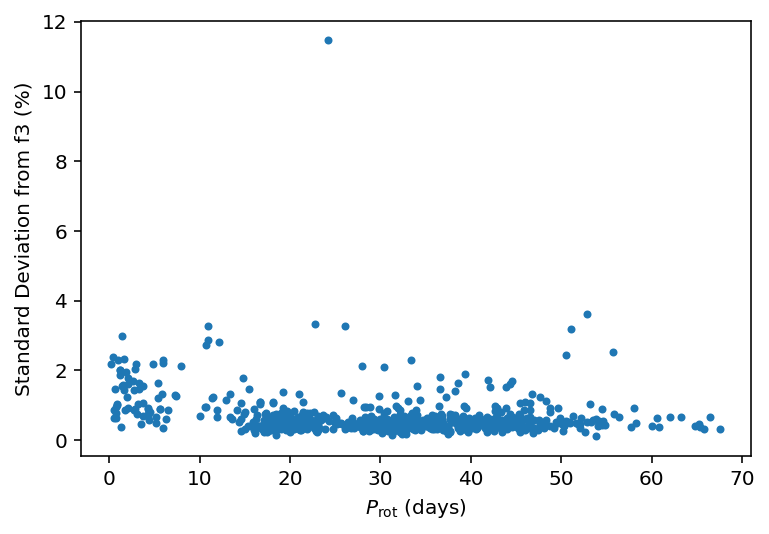

In [53]:
plt.plot(with_prot.PRot, with_prot.f3_std*100, '.')
plt.ylabel('Standard Deviation from f3 (%)')
plt.xlabel('$P_\mathrm{rot}$ (days)');

In [54]:
normalized_amp = with_prot.Rper/1e6

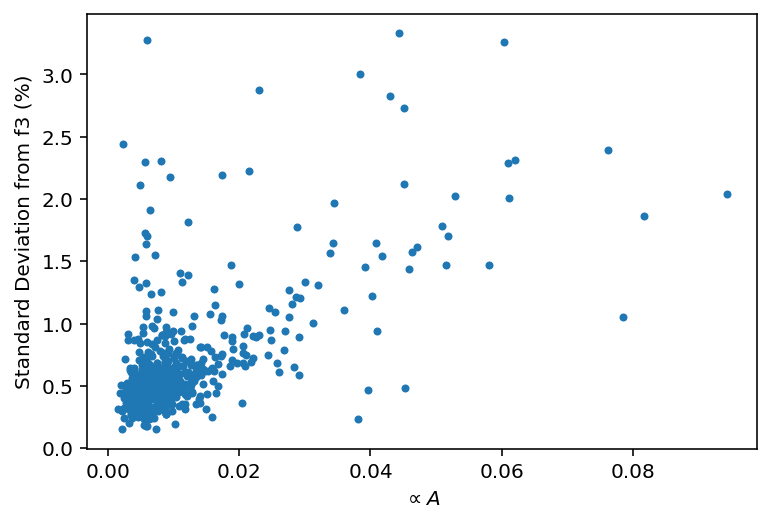

In [55]:
plt.plot(normalized_amp, with_prot.f3_std*100, '.')
plt.ylabel('Standard Deviation from f3 (%)')
plt.xlabel('$\propto A$');

In [58]:
mask = with_prot.f3_std>0.04

In [59]:
with_prot[mask]

,kepid,ra_kic,dec_kic,source_id,random_index,ra,dec,parallax,parallax_error,parallax_over_error,...,Mass,PRot,e_PRot,Rper,LPH,w,DC,Flag,heritage,f3_std
747,8712146,299.04138,44.821411,2079189171174232448,1428298448,299.041190,44.821266,3.734973,0.025538,146.251755,...,0.3518,24.183,5.101,NaN,0.319,0.1693,1.0,NaN,2.0,0.114637
798,9005690,284.94595,45.391571,2107134113882267264,1271872283,284.946634,45.391556,9.323902,0.080874,115.289513,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.054263
813,9094000,293.71967,45.466282,2127978590903468416,1199985964,293.719731,45.466316,2.782396,0.036409,76.420433,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.043056
885,9514424,285.69131,46.185219,2106544264552308864,3306197,285.691411,46.185176,2.404669,0.181971,13.214605,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.043885
1111,10462462,288.49582,47.640781,2130925350782879616,616027986,288.495841,47.640810,1.474123,0.050783,29.027803,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.052027
1227,11068835,282.69370,48.688358,2143730641155614592,894026482,282.693730,48.688267,3.140471,0.040798,76.975937,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.043322


In [61]:
mask.sum()

6

### What are these large amplitude `f3` variables?

Text(0.5, 1.0, '11068835')

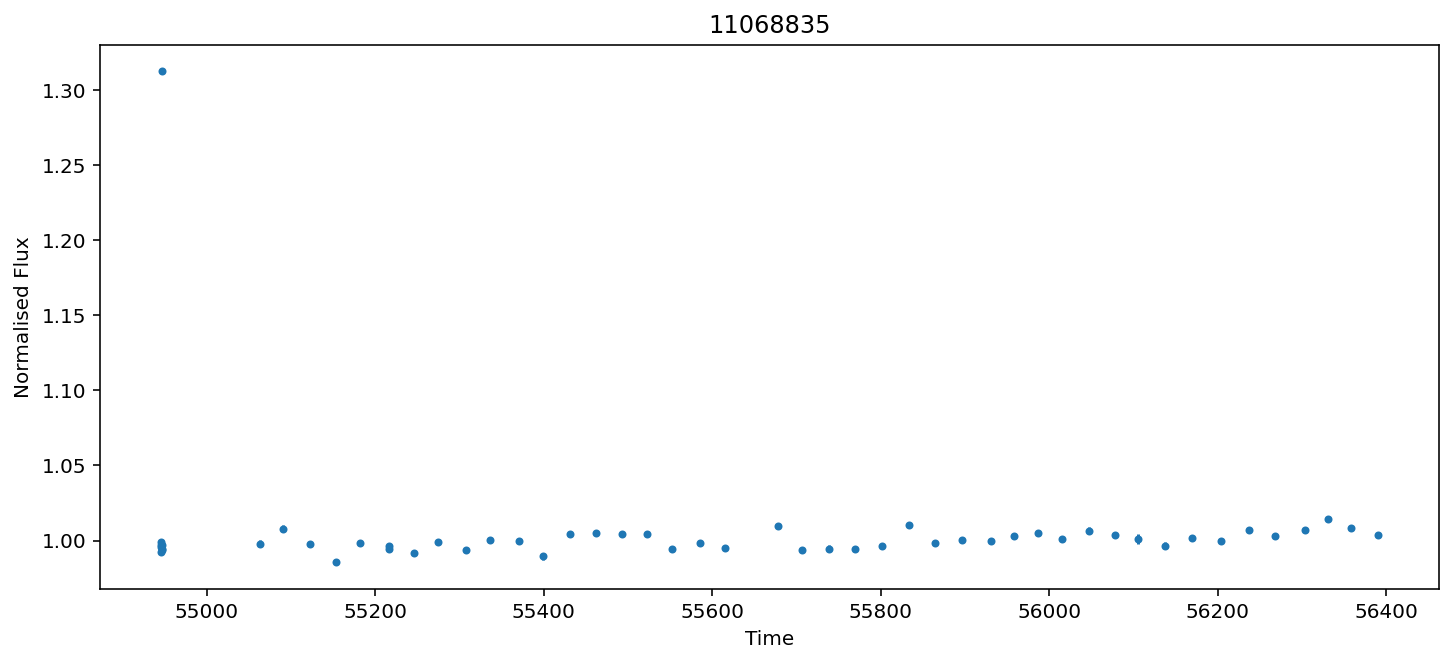

In [67]:
kepid = with_prot.iloc[1227].kepid
flux = ffidata[ffidata['KIC'] == kepid].iloc[:,1:53]
yerr = ffidata[ffidata['KIC'] == kepid].iloc[:,-52:]

plt.figure(figsize=(12,5))
plt.errorbar(times, np.asarray(flux)[0], yerr=np.asarray(yerr)[0], fmt='.')
plt.xlabel('Time')
plt.ylabel('Normalised Flux')
plt.title(kepid)

In [68]:
with_prot.to_csv('control_sample.csv')

In [ ]:
pd